<a href="https://colab.research.google.com/github/kty3452/ML-Class/blob/main/WISDM_AE_Jogging_vs_Sitting_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# WISDM 오토인코더 v4 — **Jogging(정상) vs Sitting(이상)**

**문제 진단(요약)**  
- AE가 **정상(Jogging)**보다 **이상(Sitting)**을 더 쉽게 재구성 → Sitting 점수가 낮아져 **재현율 0**.  
- 임계치 스윕이 데이터 불균형/분포 겹침에 취약.

**개선 핵심(v4)**  
1) **정상만 스케일링**(누수 방지, Jogging으로 `fit`)  
2) **1D-CNN AE + MAE 손실**(시계열 구조 반영, 강건)  
3) **복합 점수** = MAE/MSE/마할라노비스 + **동역학·스펙트럼 패널티**  
   - Jogging은 **큰 변화량/유효 주파수 피크**가 필수 → Sitting에는 **부족** → 패널티로 격차 확대  
4) **밸런스드 임계치 스윕**(정상=이상 동수로 검증셋 구성, F1 최대화)  
5) (선택) **Subject-wise 평가** 블록


## 1) 파라미터

In [3]:
import os, numpy as np, pandas as pd
CSV_PATH = os.getenv("WISDM_CSV", "/content/drive/MyDrive/ML_Class/WISDM.csv")
NORMAL_ACTIVITY  = "Jogging"
ANOMALY_ACTIVITY = "Sitting"

WINDOW_SIZE = int(os.getenv("WINDOW_SIZE", 128))
STEP_SIZE   = int(os.getenv("STEP_SIZE", 64))

VAL_SPLIT   = float(os.getenv("VAL_SPLIT", 0.2))
EPOCHS      = int(os.getenv("EPOCHS", 60))
BATCH_SIZE  = int(os.getenv("BATCH_SIZE", 256))
LR          = float(os.getenv("LR", 1e-3))

# 점수 가중치
W_MAE   = 0.45
W_MSE   = 0.15
W_MAHAL = 0.20
W_DYN   = 0.15
W_PEAK  = 0.05

CSV_PATH, NORMAL_ACTIVITY, ANOMALY_ACTIVITY


('/content/drive/MyDrive/ML_Class/WISDM.csv', 'Jogging', 'Sitting')

## 2) 데이터 로드

In [4]:
def load(csv_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(csv_path, header=None)
        if df.shape[1] < 7:
            raise ValueError("7열 미만")
        df = df.iloc[:, :7]
        df.columns = ['idx','user','activity','timestamp','x','y','z']
    except Exception:
        df = pd.read_csv(csv_path)
        lower = [c.lower() for c in df.columns]
        km = {
            'idx': ['idx','index','row','sequence'],
            'user': ['user','subject','participant','uid'],
            'activity': ['activity','label','act','state'],
            'timestamp': ['timestamp','time','ts','datetime'],
            'x': ['x','accel_x','acc_x','x_axis'],
            'y': ['y','accel_y','acc_y','y_axis'],
            'z': ['z','accel_z','acc_z','z_axis'],
        }
        name_map = {}
        for k, cands in km.items():
            for cand in cands:
                if cand in lower:
                    name_map[k] = df.columns[lower.index(cand)]
                    break
        req = ['idx','user','activity','timestamp','x','y','z']
        if set(name_map) != set(req):
            raise ValueError("헤더 매핑 실패 — CSV 컬럼명 확인")
        df = df.rename(columns={name_map[k]:k for k in name_map})[req]
    return df

df = load(CSV_PATH).copy()
for c in ['user','timestamp','x','y','z']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=['user','activity','timestamp','x','y','z']).sort_values(['user','timestamp']).reset_index(drop=True)
print("모양:", df.shape)
print("활동 상위 10개:")
display(df['activity'].value_counts().head(10))


모양: (1048575, 7)
활동 상위 10개:


,count
activity,
Walking,406775
Jogging,325975
Upstairs,118589
Downstairs,97813
Sitting,54876
Standing,44547


## 3) 윈도화 — 정상 스케일러 + (N,W,3) 시퀀스

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def windowize_seq_two_class_normal_scaler(df, window:int, step:int, normal_label:str, anomaly_label:str):
    scaler = StandardScaler()
    norm_rows = df[df['activity']==normal_label][['x','y','z']].values
    if len(norm_rows) < 100:
        raise ValueError(f"정상({normal_label}) 데이터 부족")
    scaler.fit(norm_rows)

    df2 = df[df['activity'].isin([normal_label, anomaly_label])].copy()
    df2[['x','y','z']] = scaler.transform(df2[['x','y','z']])

    X_list, y_list, labs, ts_list = [], [], [], []
    for (user, activity), grp in df2.groupby(['user','activity'], sort=False):
        vals = grp[['x','y','z']].values
        ts   = grp['timestamp'].values
        n = len(vals)
        if n < window: continue
        for st in range(0, n - window + 1, step):
            X_list.append(vals[st:st+window])
            y_list.append(0 if activity == normal_label else 1)
            labs.append(activity)
            ts_list.append(ts[st:st+window])
    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.int32)
    T = ts_list  # list of arrays
    return X, y, T

X_seq, y, T_list = windowize_seq_two_class_normal_scaler(df, WINDOW_SIZE, STEP_SIZE, NORMAL_ACTIVITY, ANOMALY_ACTIVITY)
X_seq.shape, int((y==0).sum()), int((y==1).sum())


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


((5875, 128, 3), 5049, 826)

## 4) 학습/검증 분할 — 정상만

In [6]:
from sklearn.model_selection import train_test_split
Xn = X_seq[y==0]
X_train, X_val = train_test_split(Xn, test_size=VAL_SPLIT, random_state=42, shuffle=True)
X_train.shape, X_val.shape


((4039, 128, 3), (1010, 128, 3))

## 5) 1D-CNN 오토인코더 (MAE)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Dropout, UpSampling1D, Conv1DTranspose
from tensorflow.keras.optimizers import Adam

def build_cnn_ae(input_shape, lr=1e-3):
    inp = Input(shape=input_shape, name='inp')
    x = Conv1D(32, 5, padding='same', strides=1)(inp); x = BatchNormalization()(x); x = ReLU()(x)
    x = Conv1D(64, 5, padding='same', strides=2)(x);   x = BatchNormalization()(x); x = ReLU()(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 3, padding='same', strides=2)(x);   x = BatchNormalization()(x); x = ReLU()(x)
    x = Conv1D(128,3, padding='same', strides=2)(x);   x = BatchNormalization()(x); x = ReLU()(x)
    z = Conv1D(32, 1, padding='same', strides=1, name='latent')(x)
    try:
        x = Conv1DTranspose(64, 3, padding='same', strides=2)(z)
    except Exception:
        x = UpSampling1D(2)(z); x = Conv1D(64, 3, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x)
    try:
        x = Conv1DTranspose(64, 3, padding='same', strides=2)(x)
    except Exception:
        x = UpSampling1D(2)(x); x = Conv1D(64, 3, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x)
    try:
        x = Conv1DTranspose(32, 5, padding='same', strides=2)(x)
    except Exception:
        x = UpSampling1D(2)(x); x = Conv1D(32, 5, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x)
    out = Conv1D(3, 3, padding='same', activation='linear', name='recon')(x)
    model = Model(inp, out, name='cnn_ae_wisdm_v4')
    model.compile(optimizer=Adam(LR), loss='mae')
    return model

ae = build_cnn_ae(X_seq.shape[1:])
ae.summary()


Model: "cnn_ae_wisdm_v4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inp (InputLayer)                │ (None, 128, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 32)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Conv1D)                 │ (None, 16, 32)         │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 32, 64)         │         6,208 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 64, 64)         │        12,352 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 64, 64)         │             

 Total params: 82,915 (323.89 KB)

 Trainable params: 82,019 (320.39 KB)

 Non-trainable params: 896 (3.50 KB)

## 6) 학습 (EarlyStopping + LR Reduce)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', patience=8, mode='min', restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1)
history = ae.fit(X_train, X_train, validation_data=(X_val, X_val),
                 epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[es, rlr], verbose=1)
min(history.history['val_loss'])


Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 558ms/step - loss: 0.8529 - val_loss: 0.7669 - learning_rate: 0.0010
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.5812 - val_loss: 0.7351 - learning_rate: 0.0010
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4961 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4506 - val_loss: 0.6509 - learning_rate: 0.0010
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4242 - val_loss: 0.6087 - learning_rate: 0.0010
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4036 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3863 - val_loss: 0.5122 - learning_rate: 0.0010
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3708 - val_loss: 0.4709 - learning_rate: 0.0010
Epoch 9/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3556 - val_loss: 0.4245 - learning_rate: 0.0010
Epoch 10/60
16/16

0.17012041807174683

## 7) 이상 점수 — MAE/MSE/마할 + 동역학/스펙트럼 패널티

In [9]:
import numpy as np
from tensorflow.keras.models import Model

# (a) 재구성 기반
R_all = ae.predict(X_seq, verbose=0)
MAE = np.mean(np.abs(X_seq - R_all), axis=(1,2))
MSE = np.mean(np.square(X_seq - R_all), axis=(1,2))

enc = Model(ae.input, ae.get_layer('latent').output)
Z_train = enc.predict(X_train, verbose=0).reshape([X_train.shape[0], -1])
Z_all   = enc.predict(X_seq,   verbose=0).reshape([X_seq.shape[0],  -1])

mu = Z_train.mean(axis=0, keepdims=True)
cov = np.cov(Z_train.T) + np.eye(Z_train.shape[1])*1e-6
try: inv_cov = np.linalg.inv(cov)
except np.linalg.LinAlgError: inv_cov = np.linalg.pinv(cov)

diff = Z_all - mu
MAHAL = np.sqrt(np.sum(diff @ inv_cov * diff, axis=1))

# (b) 동역학 패널티: 가속도 크기(mag) 변화량의 표준편차 부족에 대해 패널티
def mag(arr): return np.sqrt(np.sum(np.square(arr), axis=2))  # (N,W)
mag_all = mag(X_seq)
mag_train = mag(X_train)

def dyn_std(a):
    d = np.diff(a, axis=1)        # (N,W-1)
    return np.std(d, axis=1)

dyn_train = dyn_std(mag_train)
dyn_all   = dyn_std(mag_all)
mu_dyn, std_dyn = float(np.mean(dyn_train)), float(np.std(dyn_train) + 1e-8)

# Jogging은 변화량이 커야 정상 → 부족할수록 패널티
DYN_PEN = np.maximum(0.0, (mu_dyn - dyn_all) / std_dyn)

# (c) 스펙트럼 패널티: 유효 주파수대(0.5~5Hz)의 피크 진폭이 부족하면 패널티
# 샘플링 주파수 추정 (timestamp 단위 추정: ms/μs/초 혼합 가능성 → robust)
def estimate_fs(ts_batch):
    # ts_batch: list of arrays (W,)
    # 수 개 윈도에서 중앙차분 median으로 dt 추정
    dts = []
    for ts in ts_batch[: min(200, len(ts_batch))]:
        ts = np.asarray(ts)
        if ts.size < 2: continue
        dt = np.median(np.diff(ts))
        if dt <= 0: continue
        dts.append(dt)
    if not dts:
        return 20.0  # fallback
    dt_med = float(np.median(dts))
    # 단위 보정: 값이 1e3 이상이면 ms로 보고 초환산
    if dt_med > 50:   # likely milliseconds
        dt_med = dt_med / 1000.0
    elif dt_med < 1e-3: # likely microseconds
        dt_med = dt_med / 1e6
    return max(5.0, min(100.0, 1.0 / dt_med))  # clamp to reasonable

FS = estimate_fs(T_list)
from numpy.fft import rfft, rfftfreq
def peak_amp_05_5hz(x3):  # x3: (W,3)
    v = np.linalg.norm(x3, axis=1)        # (W,)
    V = np.abs(rfft(v - np.mean(v)))
    freqs = rfftfreq(v.size, d=1.0/FS)
    band = (freqs >= 0.5) & (freqs <= 5.0)
    if not np.any(band):
        return 0.0
    return float(np.max(V[band]))

# train 정상 윈도의 밴드 피크 통계
peak_train = np.array([peak_amp_05_5hz(x3) for x3 in X_train[:min(1000,len(X_train))]])
mu_peak, std_peak = float(np.mean(peak_train)), float(np.std(peak_train) + 1e-8)

peak_all = np.array([peak_amp_05_5hz(x3) for x3 in X_seq[:min(4000,len(X_seq))]])
# large set may be truncated; fill remaining with fast approx (use dyn as proxy)
if peak_all.size < len(X_seq):
    peak_all = np.pad(peak_all, (0, len(X_seq)-peak_all.size), constant_values=np.median(peak_all))

PEAK_PEN = np.maximum(0.0, (mu_peak - peak_all) / std_peak)

# 스케일 정렬: 패널티를 재구성 손실 스케일에 맞춤
scale_ref = np.median(MAE) + 1e-8
DYN_PEN  = DYN_PEN  * scale_ref
PEAK_PEN = PEAK_PEN * scale_ref

# 최종 점수
score = (W_MAE*MAE + W_MSE*MSE + W_MAHAL*MAHAL + W_DYN*DYN_PEN + W_PEAK*PEAK_PEN)
score.shape


(5875,)

## 8) 임계치 스윕 — 정상/이상 동수로 밸런스드 검증

In [10]:
from sklearn.metrics import f1_score

idx_norm = np.where(y==0)[0]
idx_anom = np.where(y==1)[0]

k = min(len(idx_norm), len(idx_anom), max(50, int(0.1*len(idx_norm))))
# 동수 샘플
rng = np.random.default_rng(42)
norm_sel = rng.choice(idx_norm, size=k, replace=False)
anom_sel = rng.choice(idx_anom, size=k, replace=False)

val_idx = np.concatenate([norm_sel, anom_sel])
y_val  = np.concatenate([np.zeros(k, dtype=int), np.ones(k, dtype=int)])
score_val = score[val_idx]

# 넓은 그리드
lo = np.percentile(score, 10)
hi = np.percentile(score, 99.9)
grid = np.linspace(lo, hi, 80)

best_f1, threshold = -1.0, None
for thr in grid:
    y_hat = (score_val > thr).astype(int)
    f1 = f1_score(y_val, y_hat, average='binary', zero_division=0)
    if f1 > best_f1:
        best_f1, threshold = f1, float(thr)
threshold, best_f1


(3.176466742661614, 0.532724505327245)

## 9) 평가

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

y_pred = (score > threshold).astype(int)

cm = confusion_matrix(y, y_pred)
pr, rc, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary', zero_division=0)
print("[혼동행렬]\n", cm)
print(f"[Precision/Recall/F1] {pr:.4f}/{rc:.4f}/{f1:.4f}")
print(classification_report(y, y_pred, target_names=['Normal(Jogging)', 'Anomaly(Sitting)']))


[혼동행렬]
 [[ 346 4703]
 [ 242  584]]
[Precision/Recall/F1] 0.1105/0.7070/0.1911
                  precision    recall  f1-score   support

 Normal(Jogging)       0.59      0.07      0.12      5049
Anomaly(Sitting)       0.11      0.71      0.19       826

        accuracy                           0.16      5875
       macro avg       0.35      0.39      0.16      5875
    weighted avg       0.52      0.16      0.13      5875



## 10) 시각화 — 손실 & 점수 분포

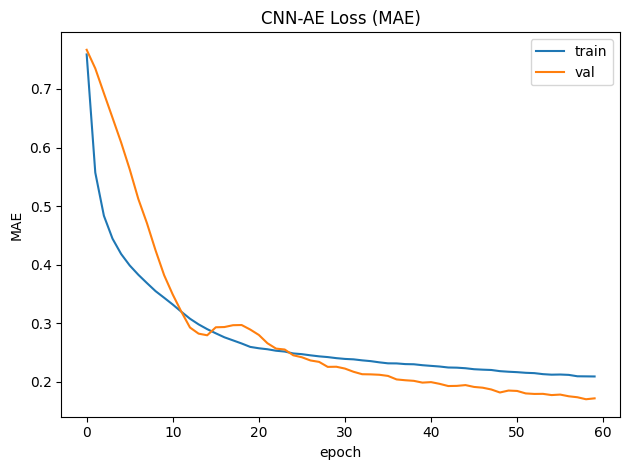

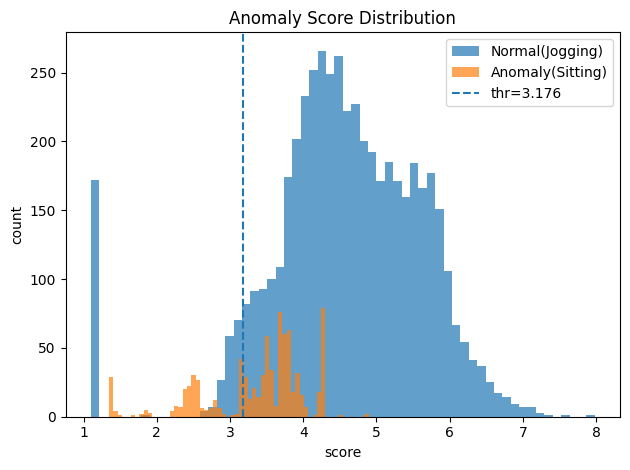

In [12]:
import matplotlib.pyplot as plt

plt.figure(); plt.plot(history.history['loss'], label='train'); plt.plot(history.history['val_loss'], label='val')
plt.title('CNN-AE Loss (MAE)'); plt.xlabel('epoch'); plt.ylabel('MAE'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.hist(score[y==0], bins=60, alpha=0.7, label='Normal(Jogging)')
plt.hist(score[y==1], bins=60, alpha=0.7, label='Anomaly(Sitting)')
plt.axvline(threshold, linestyle='--', label=f'thr={threshold:.4g}')
plt.title('Anomaly Score Distribution'); plt.xlabel('score'); plt.ylabel('count'); plt.legend(); plt.tight_layout(); plt.show()
